I built a simple predictor of prices of several establishments based on their location, category, popularity and their description on Facebook.

The original data contained +150K events, which are spread in three different datasets. These datasets contain information obtained from Facebook, Google and other sources. In total, they contained 129 fields which described aspects from each instance. They include information such as the name of a place, location, category, rating, likes and so on.

I focused on the price range of the services offered by the ventures contained in these corpora. From the data of Facebook and Google only the 2.9% of the organizations have information related to the price of their services. Then, it is useful to predict the price range that a user can pay when visiting any of these companies, because we can provide them important information to decide and encourage whether to go (for instance) to a restaurant, a spa center or a school.


In [2]:
import pandas as pd
import numpy as np
from prep import preprocessing
from Visualization import Visualization
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import decomposition
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.metrics import classification_report_imbalanced
import nltk
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
prp = preprocessing()
vsl = Visualization()

# Read all data
fb,go,fac = prp.read_data()

In [5]:
#original size of data
print("Original number of instances: ",fb.shape[0]+ go.shape[0] + fac.shape[0])
print("Original number of fields: ",fb.shape[1]+ go.shape[1] + fac.shape[1])

Original number of instances:  159586
Original number of fields:  129


In [6]:
print("Organizations with no price info in Facebook: ",fb.price_range.value_counts(dropna=False)[0])
print("Organizations with price info in Facebook: ",fb.price_range.value_counts().sum())
print("Organizations with no price info in Google: ",go.price_level.value_counts(dropna=False)[np.NaN])
print("Organizations with price info in Google: ",go.price_level.value_counts().sum())

Organizations with no price info in Facebook:  11920
Organizations with price info in Facebook:  2596
Organizations with no price info in Google:  91094
Organizations with price info in Google:  148


I filtered the 39 most useful and potential features found in the datasets. These features were selected based on the following two aspects:

    1) They contain relevant information related to price predictions
    2) They have suficient instances to feed a MAchine Learning (ML) model

In [7]:
# select potential features
fb = fb[['__location','__reference','__timestamp','_id','about','awards',
    'category','category_list','description','emails','hours', 'is_published',
    'likes','location','name', 'parking','place_topics', 'price_range', 'products', 
    'restaurant_specialties','talking_about_count','website']]

go = go[['_id','address_components','formatted_address','loc','name',
    'rating','price_level','vicinity']]

fac = fac[['name','address','locality','region','latitude',
     'longitude','neighborhood','hours','existence']]

In [8]:
print("Potential features selected: ", len(fb.columns)+len(go.columns)+ len(fac.columns))

Potential features selected:  39


After preprocessing the fields in facebook and google datasets, I kept the 16 most informative fields. The remaining 23 out of 39 fields were removed because they had problems like missing information in most of the instances, redundant information with other columns, and ambiguous or useless information related to price aspects.

In [9]:
#preprocess interesting features

#map facebook location
fb = prp.map_fb_loc(fb,'__location','coordinates',[482,8276,8280])

#keep instances with likes info
fb = prp.dropna(fb,['likes'],'any')

# extract useful information
fb['likes'] = prp.map_dict(fb,'likes','$numberLong')
go['id'] = prp.map_dict(go,'_id','$oid')

# filter most informative fields
fb = fb[['_id','name','category','price_range','about','latitude','longitude','description','likes']]
go = go[['id','name','rating','price_level']]
fac = fac[['name','hours','existence']]



print("Most informative features selected: ",len(fb.columns)+len(go.columns)+ len(fac.columns))

Most informative features selected:  16


An important step performed was merging the information of facebook and google datasets using the name of the company. By doing this, it was possible to add information such as likes, which can help to understand if people finds a given stablishment interesting. I assumed the popularity of a place in facebook can be correlated to the price level. For instance, if an establishment has a lot of likes it's very likely that prices are affordable for most of the people. On the contrary, if a local business doesn't have many likes it's likely that people find the place very expensive, then not many people is willing/capable of paying a high price. Another important feature that was included is the rating of a place, which together with likes can help to get a better understanding of the price of an establishment.



In [10]:
pd.options.mode.chained_assignment = None

tmp_df = pd.merge(fb,go, how = 'left', left_on = 'name', right_on = 'name')
df = tmp_df[['name','category','price_range','price_level','rating','about','latitude','longitude',
            'description','likes']]

print("Features selected: ",df.shape)

Features selected:  (15854, 10)



The categories of price level in facebook have a different format to those of Google, by which a simple transformation was performed. Then, the price levels are categorized into the following 4 classes:

    1) Class 1 :  Comprising prices between $0-$10 (Very cheap)
    2) Class 2 :  Comprising prices between $10-$30 (Normal)
    3) Class 3 :  Comprising prices between $30-$50 (Expensive)
    4) Class 4 :  Comprising prices between $50+    (Very expensive)
    

In [11]:
# label price
df = prp.label_price(df)

#select data to train price estimator
df = df.loc[df['price'] >= 0]
df = df.reset_index()
del df['index']

The "category" field was categorized according to the key words contained in this field. 17 categories were generated according to the similarity between the topics included in the key words. These categories are the following:

    1) home
    2) web
    3) salon
    4) media
    5) school
    6) health 
    7) gov 
    8) public
    9) fitness
    10) travel
    11) event
    12) sport
    13) entertainment
    14) company
    15) shop
    16) bar
    17) others

In [12]:
#label category
df['category'] = prp.label_category(df,'category')

The "about" field contains a brief intro of the services that a given company offers. The message of this field were tokenized, and after that I kept only the relevant words from the message, as they can also be good indicators of the services a company offers, and consequently, the price range of these services, which is our main interest.

In [13]:
#extract key words
df.about = df.about.fillna('noword')
df['rel_words'] = prp.remove_stop_wds(df,'about')

# fill NAN values with the mean rating value
df = df.fillna(df.rating.mean())

The distribution of prices per rating in the dataset is imbalanced. As observed below, the ratio of class 2 (the most populated class) over class 4 (the least popular class) is 7:1 approximately. Dealing with imbalanced classes was one of the major problems I dealt with when building this predictor. Based on that, we could expect that the classifiers perform poorly with classes 3 and 4, which are the least populated classes, as well as having high accuracy with samples of class 2. Similarly, classifiers might confuse unseen reviews with the most populated class (i.e. rating 2) if techniques to deal with imbalanced classes are not considered during the training stage.

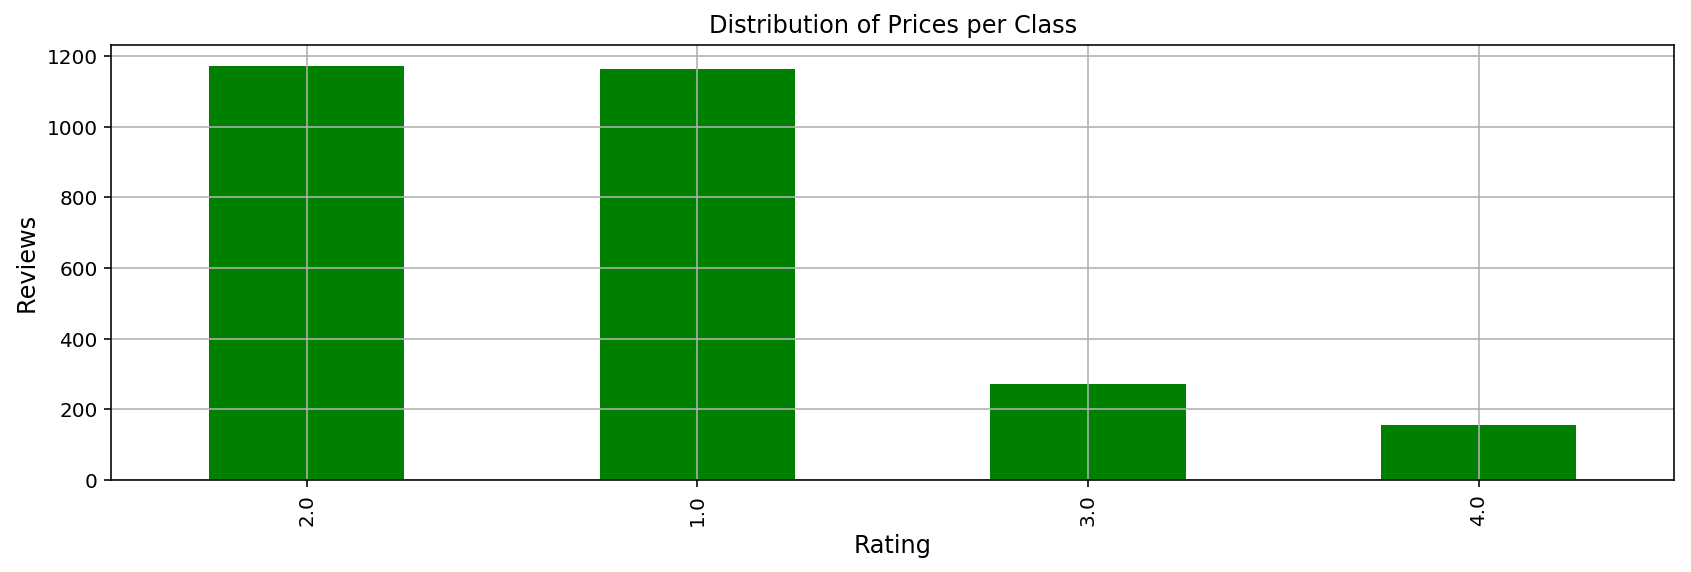

In [14]:
df.price.value_counts().plot(kind='bar',figsize=(14,4),grid=True,
                                     title="Distribution of Prices per Class",
                                  color='green')
plt.ylabel('Reviews',size=12)
plt.xlabel('Rating',size=12)
plt.show()

# Building the model

A Bag-of-words was used to build a vector that can feed the model trained below. In addition, the following 5 features were included as the features for training the classifier:
    
    1) category
    2) rating
    3) latitude
    4) longitude
    5) likes

In [24]:
shuffle(df)
# Bag-of-words
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, 
                             preprocessor = None)
RANDOM_STATE = 0
seed = 18
np.random.seed(seed)


In [25]:
#ADD MORE FEATURES
add_feats = df[['category','rating','latitude','longitude','likes']]
a_feats = add_feats.values

In order to extract the main features from both the bag-of-words vector and the additional features included, I used PCA for extracting the 10 most important components within the data.

In [26]:
train_size = 0.7
add_feats = True
x_fts = vectorizer.fit_transform(df['rel_words'])
x_fts = x_fts.toarray()

if add_feats:
    x_fts = np.concatenate((x_fts,a_feats),axis=1)

#x_fts = a_feats

#PCA extraction
pca = decomposition.PCA(n_components=10)
pca.fit(x_fts)
x_fts = pca.transform(x_fts)
    
train_size = int(len(x_fts)* train_size)
x_train, y_train = x_fts[0:train_size], df['price'][0:train_size]
X_test, Y_test = x_fts[train_size:], df['price'][train_size:]

I took advantage of sampling techniques in order to tackle the extremely imbalanced data observed in the train and test subsets. After comparing undersampling and oversampling techniques, undersampling showed a better performance in comparison to overersampling. Then, a random oversampling in the least popular classes was implemented.

In [27]:
ros = RandomUnderSampler(random_state=RANDOM_STATE)

x_train, y_train = ros.fit_sample(x_train, y_train)

After implementing the RandomOverSampler technique, the distribution of the oversampled data is illustrated below. The ratio in the training and testing data is 1:1 between the most and the least popular classes. The training data contains 115 instances for each of the 4 classes. As observed, the biggest impact of implementing undersampling is reducing the number of instances from our original dataset, and consequently, from each of the classes. 

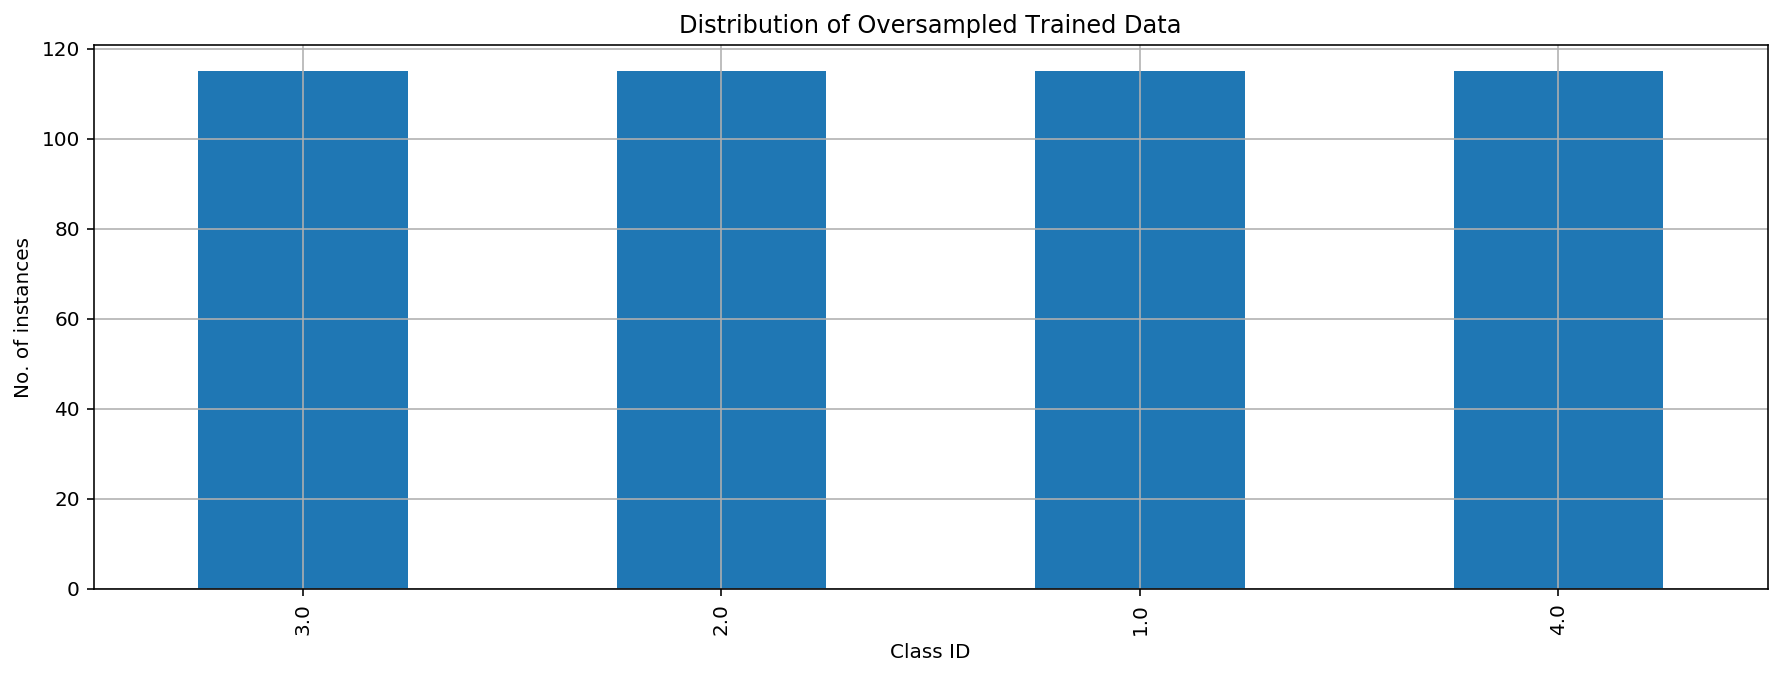

Oversampled Trained Data shape Counter({1.0: 115, 2.0: 115, 3.0: 115, 4.0: 115})


In [28]:
vsl.counter(y_train,"Oversampled Trained Data")

Greedy Search and Cross-validation were two important techniques used during the training stage. First, a Greedy search was performed to determine a potential area of convergence for the model, and find the optimal set of parameters of the classifier trained. Cross-validation was also considered with the purpose of avoiding overfitting.

The approach used was a Random Forest Classifier with 25 trees. After evaluating several models, this approach proves to have the better performance among other approaches such as K-NN, SVM and Naive Bayes. For this reason, the Random Forest Classifier was selected.

The metrics used were precision, recall and F-score as considering traditional accuracy might not represent the true behaviour of the classifier because of the imbalanced classes problem. 

After performing cross-validation, the RFC model is expected to have 41% of precision, 57% of recall and 92% of F-score with the best model trained.

In [29]:
cross_validation =   StratifiedKFold (y_train,n_folds=5, random_state=RANDOM_STATE)

scores = []
confusion_matrices = []
clf_models = []
avgs = []

for train_index,test_index in cross_validation:

    clf = None

    dx_train, dy_train = x_train[train_index], y_train[train_index]
    dx_test, dy_test = x_train[test_index], y_train[test_index]
    
    clf = RandomForestClassifier(n_estimators= 25, n_jobs=-1)
    clf.fit(dx_train, dy_train)
    clf_models.append(clf)
    
    # Saving the scores.
    test_score = clf.score(dx_test, dy_test)
    test_preds = clf.predict(dx_test)
    rep = classification_report_imbalanced(dy_test, test_preds)
    txt_rep = nltk.word_tokenize(rep[428:])
    
    avg_total = [float(txt_rep[i]) for i in range(3,len(txt_rep))]
    avgs.append(avg_total)
    scores.append(test_score)


    # Saving the confusion matrices.
    data_classes_pred = clf.predict(dx_test) 
    cm = confusion_matrix(dy_test, test_preds)
    confusion_matrices.append(cm)
    
print('Average precision :', str(np.mean([avgs[i][0] for i in range(len(avgs))])))
print('Average recall :', str(np.mean([avgs[i][1] for i in range(len(avgs))])))
print('Average F-score :', str(np.mean([avgs[i][3] for i in range(len(avgs))])))

Average precision : 0.41
Average recall : 0.57
Average F-score : 92.0


In [30]:
# Fitting  the model
clf = RandomForestClassifier(n_estimators= 25, n_jobs=-1,random_state=RANDOM_STATE)
clf.fit(x_train,y_train)
test_preds = clf.predict(X_test)

The model 
Comparing the values observed within the cross-validation it's clear that the values of recall and F-score are lower.

In [31]:
print(classification_report_imbalanced(y_pred=test_preds,y_true=Y_test))

                   pre       rec       spe        f1       geo       iba       sup

        1.0       0.50      0.32      0.72      0.39      0.52      0.27       390
        2.0       0.46      0.30      0.77      0.36      0.54      0.28       332
        3.0       0.12      0.28      0.82      0.17      0.33      0.10        68
        4.0       0.06      0.31      0.75      0.10      0.23      0.05        39

avg / total       0.44      0.31      0.75      0.35      0.50      0.25       829



As observed in the confusiion matrix shown below, the RFC was one of the models with better metrics performance.
Class 1 and class4 are predicted more accurately by the model. However, it is also clear that the model built makes strong assumptions which are reflected in the missclasification of prices as very cheap (class 1) or very expensive (class 4). One of the reasons that might be causing this missclasification is the assumption we took to fill some instances with the mean rating in order to avoid missing that data. Working on improving this assumption can be considered as a next step to enhance this proof of concept. In addition, the number of instances used for training the model plays an important role in the low performance of the model. Then, by adding more instances to fit the model and improving the quality of the data it's possible to build a classifier with a better classification performance. 

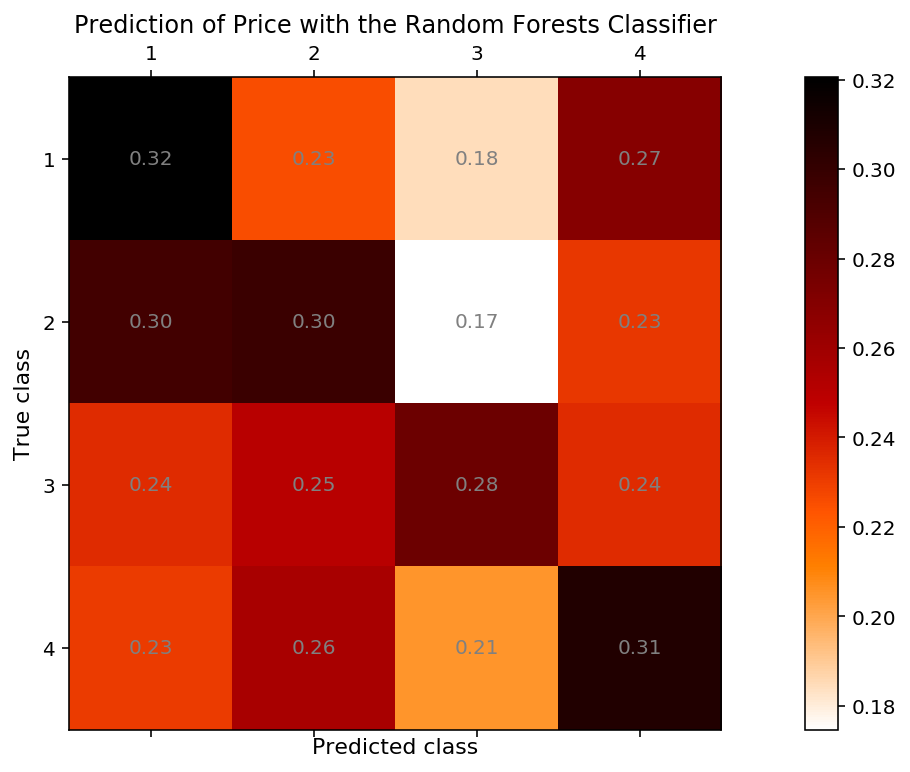

In [32]:
vsl.plot_confusion_matrix(Y_test, test_preds, 
                          'Prediction of Price with the Random Forests Classifier',color='gray')